In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k

Saving kaggle.json to kaggle.json
 99% 1.61G/1.62G [00:15<00:00, 142MB/s]
100% 1.62G/1.62G [00:16<00:00, 108MB/s]


In [ ]:
!mkdir /content/Dataset
!unzip -q /content/ocular-disease-recognition-odir5k.zip -d /content/Dataset
!rm /content/ocular-disease-recognition-odir5k.zip

In [ ]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
from skimage import filters
import cv2
from google.colab.patches import cv2_imshow
from skimage.filters import prewitt_h,prewitt_v, sobel
from skimage import feature
import imageio
%matplotlib inline 

In [ ]:
BASE_DIR = "/content/Dataset/ODIR-5K/ODIR-5K"
print(os.listdir(BASE_DIR))
data_df = pd.read_excel(open(os.path.join(BASE_DIR, 'data.xlsx'), 'rb'), sheet_name='Sheet1')  
data_df.head()

['Testing Images', 'data.xlsx', 'Training Images']


,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1


In [ ]:
data_df.columns = ["id", 'age', "sex", "left_fundus", "right_fundus", "left_diagnosys", "right_diagnosys", "normal",
                  "diabetes", "glaucoma", "cataract", "amd", "hypertension", "myopia", "other"]
data_df.head()

,id,age,sex,left_fundus,right_fundus,left_diagnosys,right_diagnosys,normal,diabetes,glaucoma,cataract,amd,hypertension,myopia,other
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1


In [ ]:
TRAIN_IMAGE_PATH = os.path.join(BASE_DIR, "Training Images")



def show_images(df, title="Diagnosys", eye_exam="left_fundus"):
    print(f"{title}; eye exam: {eye_exam}")
    f, ax = plt.subplots(3,3, figsize=(16,16))
    for i,idx in enumerate(df.index):
        dd = df.iloc[idx]
        image_name = dd[eye_exam]
        image_path = os.path.join(TRAIN_IMAGE_PATH, image_name)
        img_data=imageio.imread(image_path)
        ax[i//3, i%3].imshow(img_data)
        ax[i//3, i%3].axis('off')
    plt.show()

def show_segmentation(df, title="Segmentation", eye_exam="left_fundus"):
    print(f"{title}; eye exam: {eye_exam}")
    f, ax = plt.subplots(9,5, figsize=(17,30))
    for i,idx in enumerate(df.index):
        dd = df.iloc[idx]
        image_name = dd[eye_exam]
        image_path = os.path.join(TRAIN_IMAGE_PATH, image_name)
        # img_data=imageio.imread(image_path)
        img = cv2.imread(image_path ,cv2.IMREAD_COLOR)
        gray_img = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)

        # prewitt kernel
        pre_hor = prewitt_h(gray_img)
        pre_ver = prewitt_v(gray_img)
        # Sobel Kernel
        ed_sobel = sobel(gray_img)
        #canny algorithm
        can = feature.canny(gray_img, sigma=0.01)

        ax[i, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax[i, 0].set_title('Original', fontsize=12)

        ax[i, 1].imshow(pre_hor, cmap='gray')
        ax[i, 1].set_title(r'Prewitt Kernel Horizontal', fontsize=12)

        ax[i, 2].imshow(pre_ver, cmap='gray')
        ax[i, 2].set_title(r'Prewitt Kernel Vertical', fontsize=12)

        ax[i, 3].imshow(ed_sobel, cmap='gray')
        ax[i, 3].set_title(r'Sobel Kernel', fontsize=12)

        ax[i, 4].imshow(can, cmap='gray')
        ax[i, 4].set_title(r'Canny filter', fontsize=12)
    plt.show()

Left eye with galucoma; eye exam: left_fundus


<ipython-input-28-366f2a273a4d>:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_data=imageio.imread(image_path)


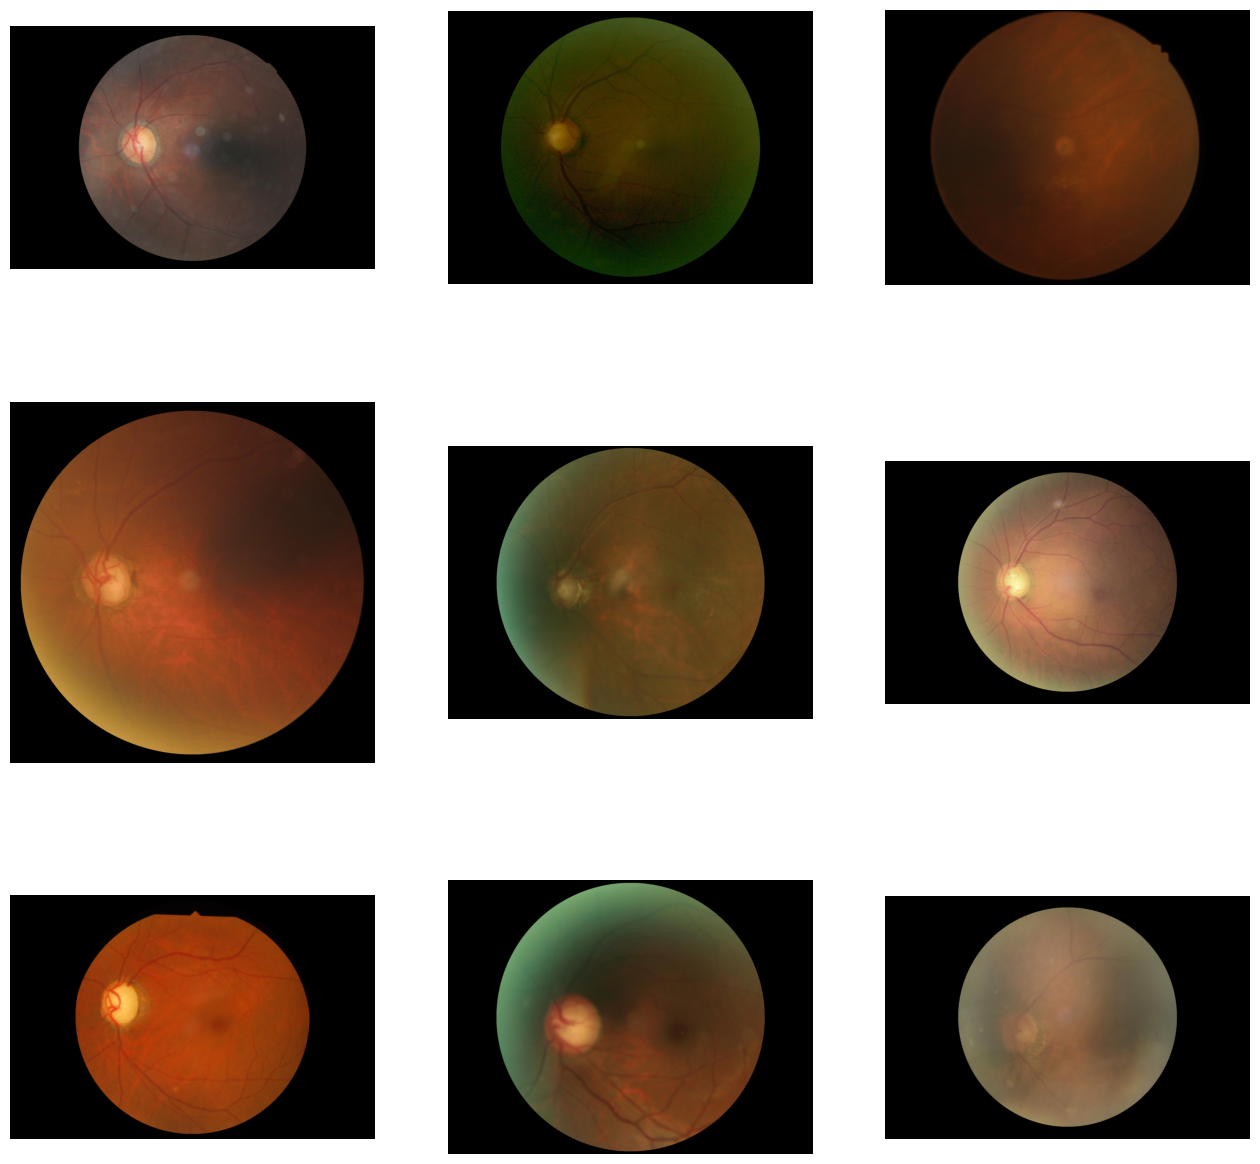

In [ ]:
df = data_df.loc[(data_df.glaucoma==1) & (data_df.left_diagnosys=="glaucoma")].sample(9).reset_index()
show_images(df,title="Left eye with galucoma",eye_exam="left_fundus")

Segmentation; eye exam: left_fundus


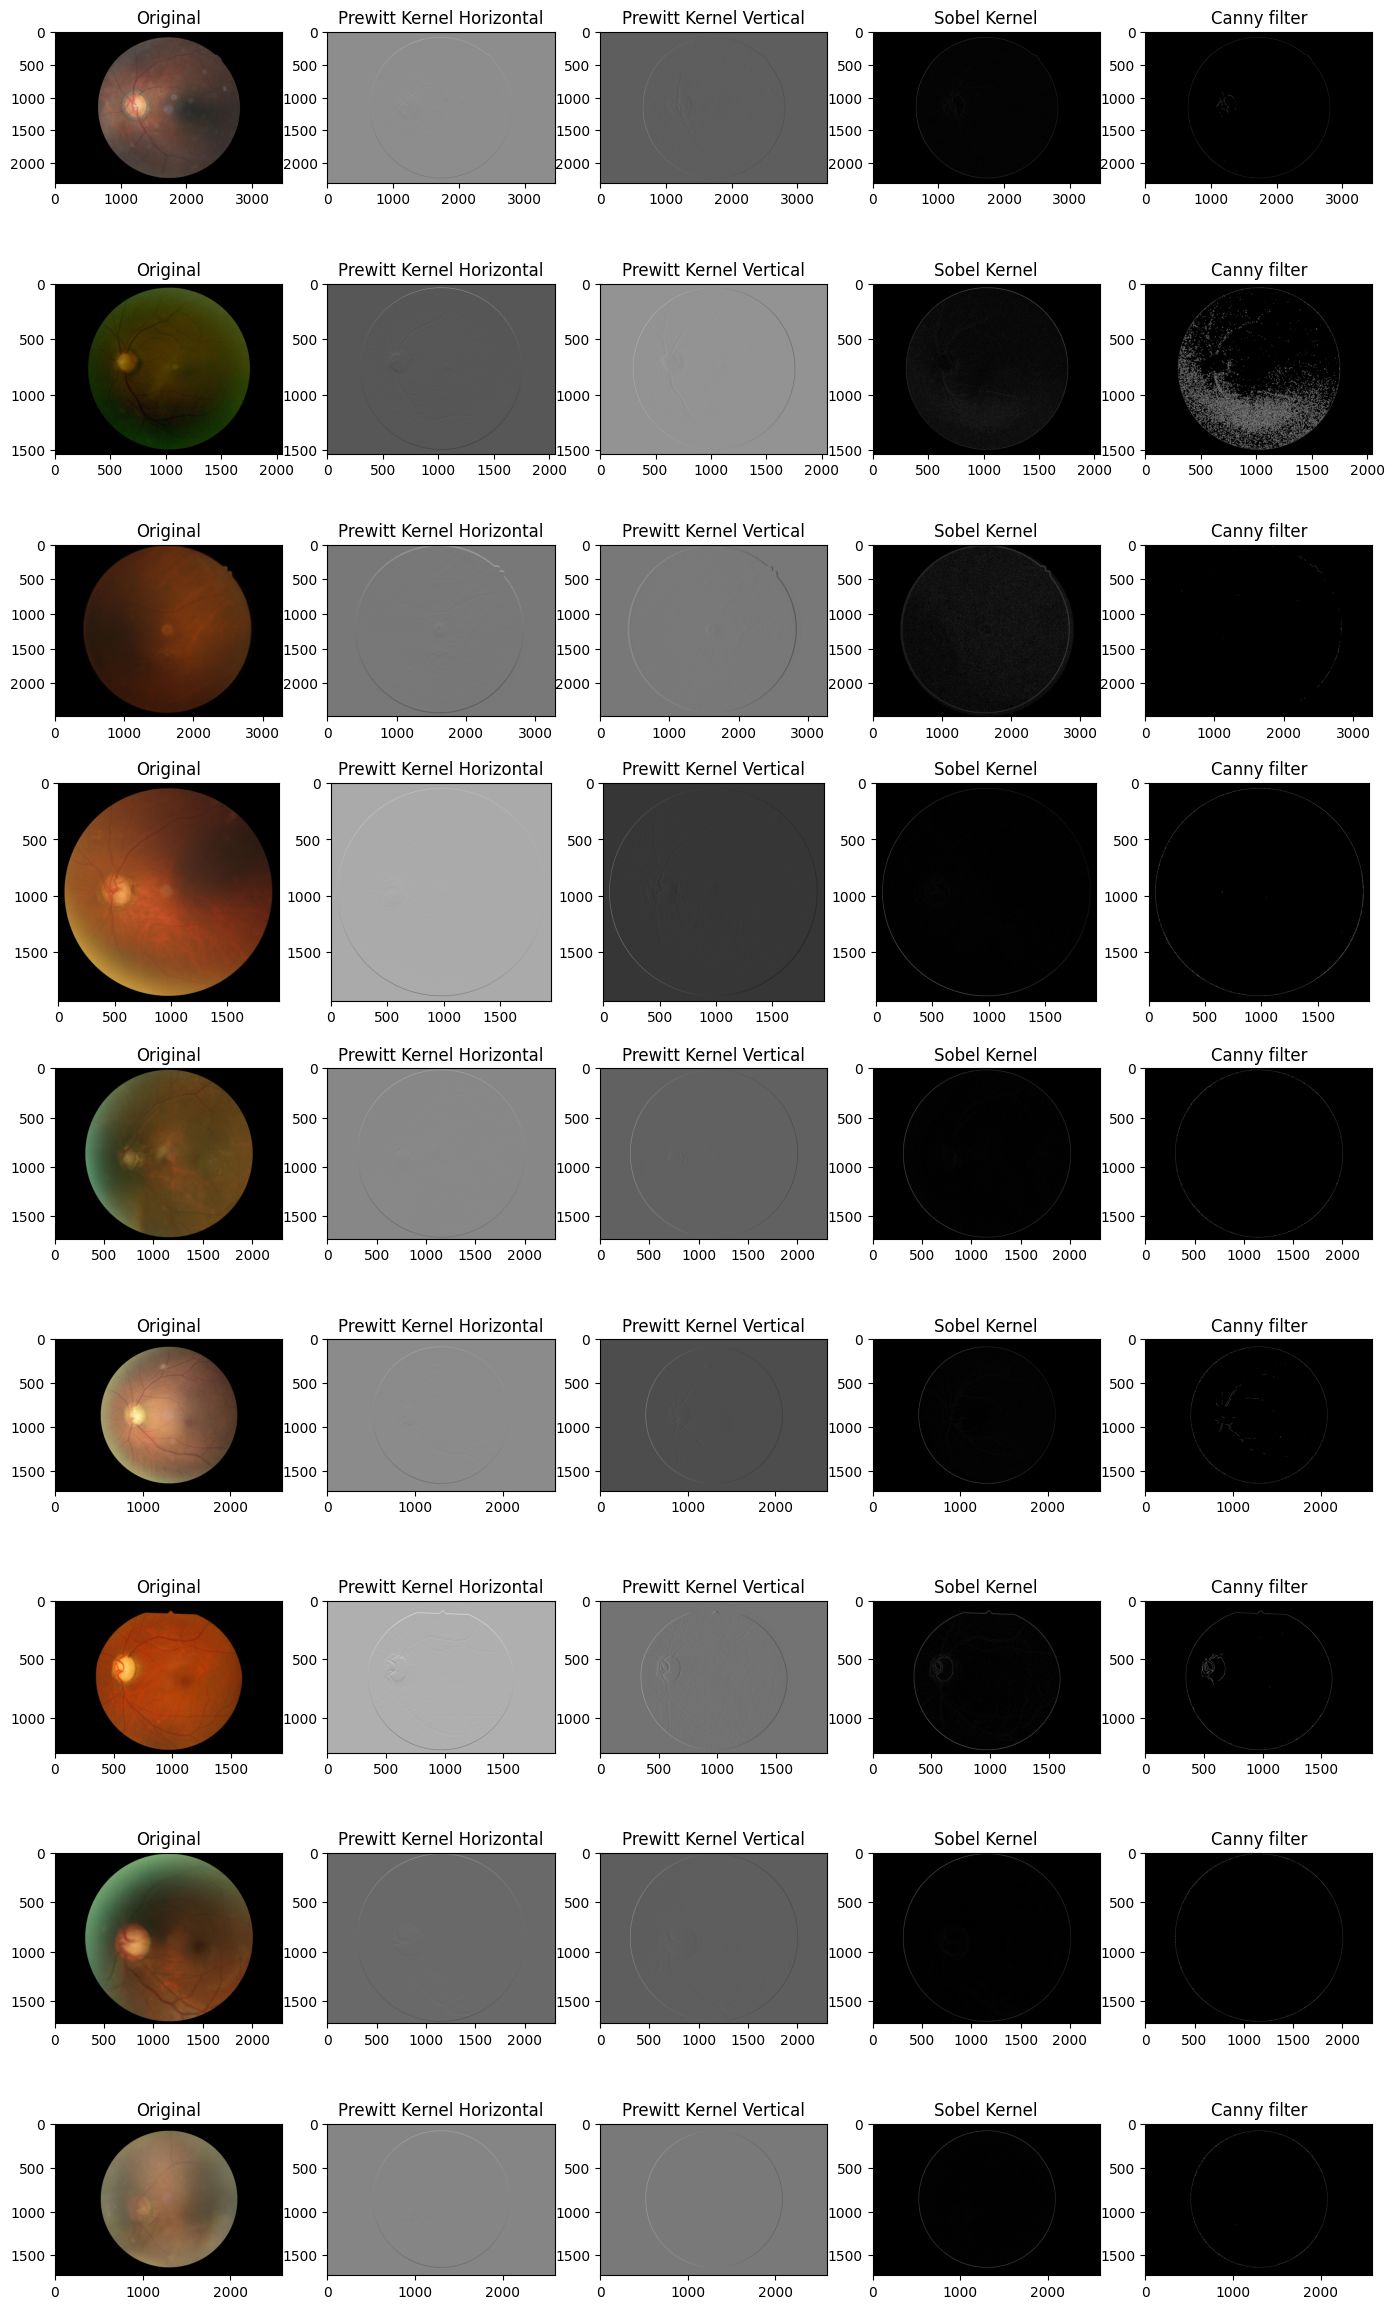

In [ ]:
show_segmentation(df,title="Segmentation",eye_exam="left_fundus")

Right eye with cataract; eye exam: right_fundus


<ipython-input-23-01fdf66acd49>:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_data=imageio.imread(image_path)


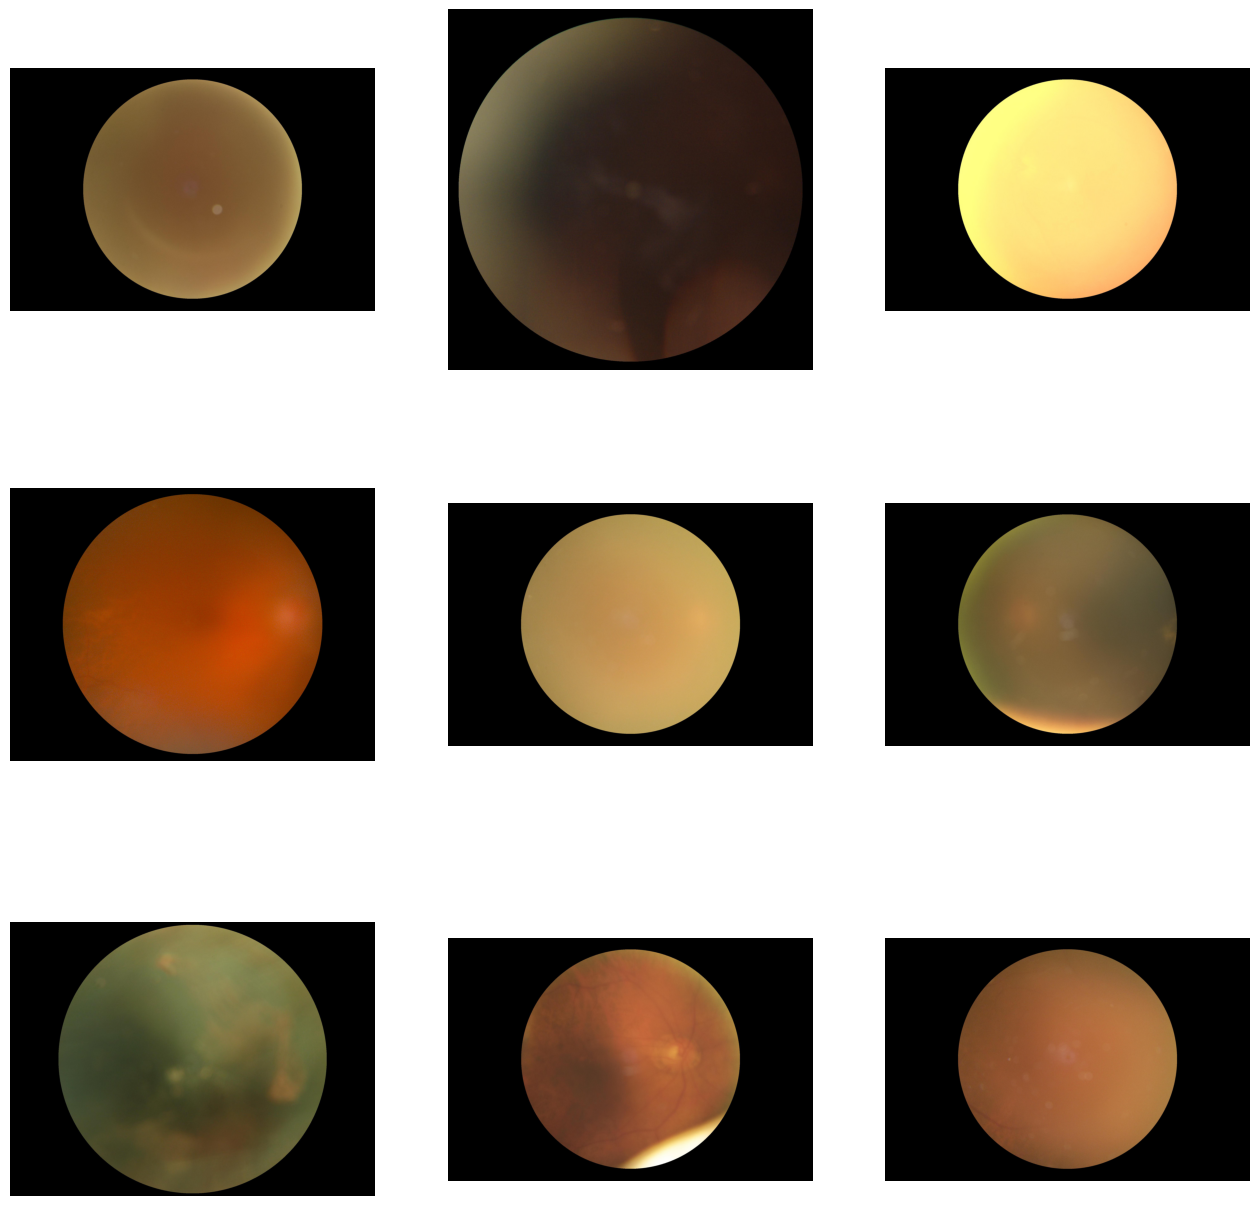

In [ ]:
df = data_df.loc[(data_df.cataract==1) & (data_df.right_diagnosys=="cataract")].sample(9).reset_index()
show_images(df,title="Right eye with cataract",eye_exam="right_fundus")

Segmentation; eye exam: right_fundus


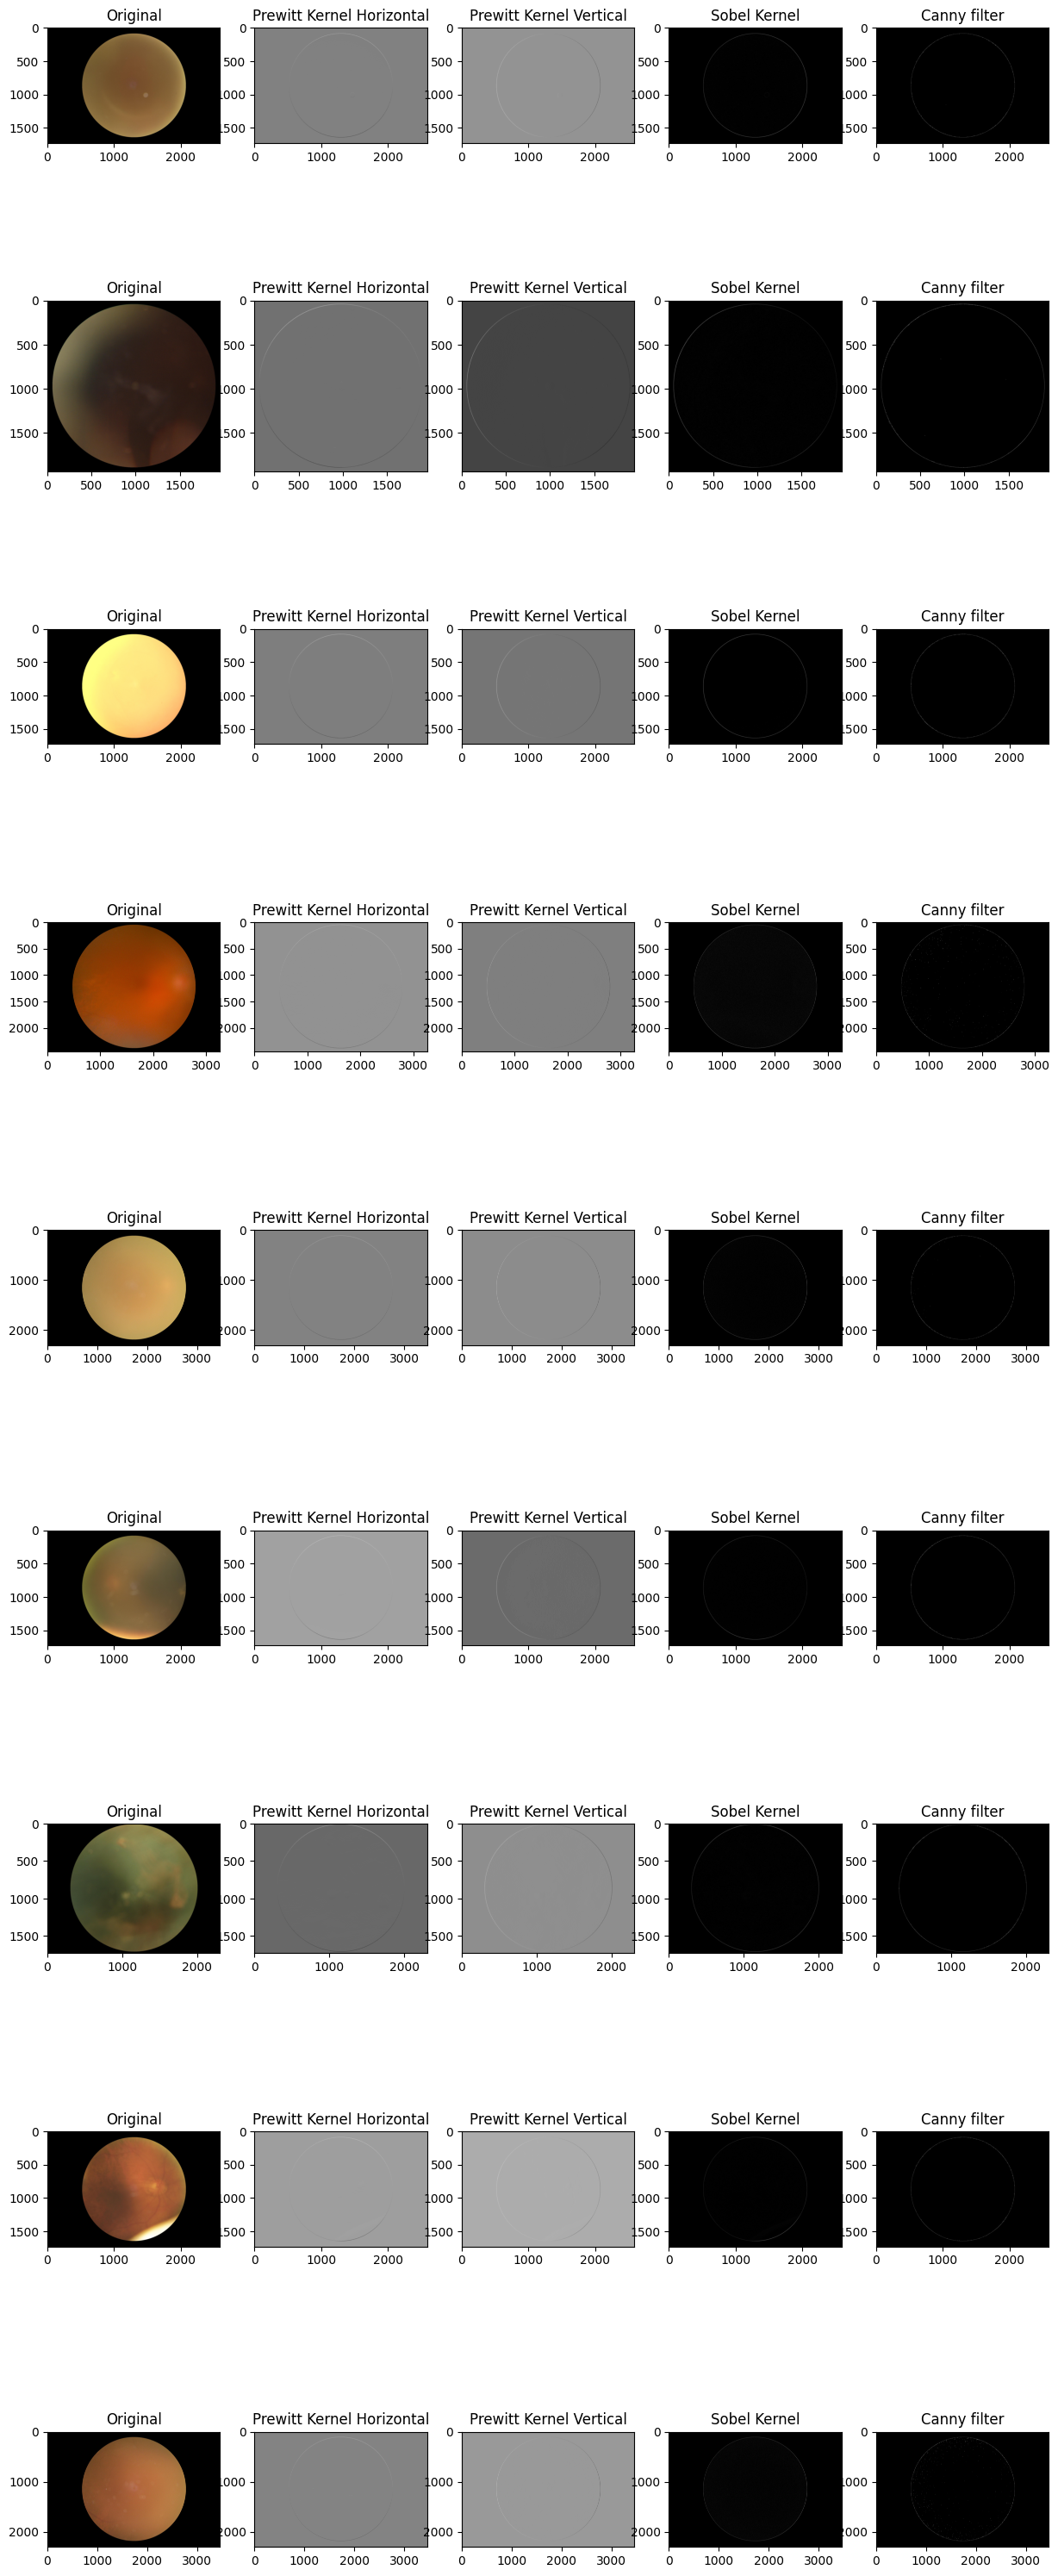

In [ ]:
show_segmentation(df,title="Segmentation",eye_exam="right_fundus")